TODO
1. open catalogs
2. get relevant information from catalogs
3. get sources that meet AGN crietera (MIR and Xray)
4. get sources that meet data restrictions
5. make full sample plots, highlight sources to be used in paper

In [1]:
# imports
from astropy.io import fits
import matplotlib.pyplot as plt
import plotting as myP
import numpy as np
# import csv 
import match

In [2]:
# path variables 
path_cat = 'D:\\IfA REU\\Catalogs'
path_fig = 'D:\\IfA REU\\IfA-REU-Project\\Figures'
path_csv = 'D:\\IfA REU\\IfA-REU-Project\\Lists'

In [3]:
# set style
myP.SetStyle()

# Get Data

In [4]:
# open COSMOS2020 catalog and get data 
inf20 = fits.open(path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits')
data20 = inf20[1].data
cols20 = inf20[1].columns
inf20.close()
# NOTE: Only run this once! It gets stuck if you try to run this again. If it gets stuck, interrupt and restart the jupyter kernel then run again. 

In [5]:
# open C-COSMOS 2016 catalog file and get data 
inf16 = fits.open(path_cat+'\\chandra_COSMOS_legacy_opt_NIR_counterparts_20160113_4d.fits')
data16 = inf16[1].data
cols16 = inf16[1].columns
inf16.close()
# NOTE: Only run this once! It gets stuck if you try to run this again. If it gets stuck, interrupt and restart the jupyter kernel then run again. 

In [6]:
# open table with redshifts 
zTable = np.array(myP.ReadFile(path_cat+'\COSMOS_z_matches.csv'))

Cropped:  ['ID', 'z']


# Read relevant columns from catalogs

In [23]:
# get columns from COSMOS2020 for MIR selection 
data20_id       = np.array(data20['ID_COSMOS2015'])     # id
data20_ch1      = np.array(data20['SPLASH_CH1_FLUX'])   # 3.5686 um
data20_ch2      = np.array(data20['SPLASH_CH2_FLUX'])   # 4.5067 um
data20_ch3      = np.array(data20['SPLASH_CH3_FLUX'])   # 5.7788 um
data20_ch4      = np.array(data20['SPLASH_CH4_FLUX'])   # 7.9958 um 
data20_24um     = np.array(data20['FIR_24_FLUX'])       # Spitzer/MIPS.24mu
data20_24umErr  = np.array(data20['FIR_24_FLUXERR'])    # Spitzer/MIPS.24mu error 

In [8]:
# get columns from C-COSMOS 2016 for X-ray selection 
L0510_data = np.array(data16['Lx_0510'])            # x-ray luminosity in the 0.5-10 KeV band
k0510_data = np.array(data16['abs_corr_0510'])      # absorbtion correction coefficient in the 0.5-10 KeV band
data16_id    = np.array(data16['id_k_uv'])          # id 

In [9]:
# get redshifts 
zTable_id, zTable_z = zTable.T # transpose to get columns 
zTable_id = np.array(zTable_id, dtype=int) # get correct data type
zTable_z  = np.array(zTable_z,  dtype=float)

# Data Cuts
1. Must have id
2. must have redshift
3. must have all four IRAC detections
4. must have 24um detection with fractional error < 50%

In [10]:
def IndexToMask(iList, size) : 
    mask = np.zeros(size, dtype=bool)
    mask[iList] = True 
    return(mask)

In [11]:
# 1. all sources must have id 

# data cut mask 
data20_id_cut1 = (data20_id > 0)    # mask to be used on data20 cols
data16_id_cut1 = (data16_id > 0)    # mask to be used on data16 cols

In [14]:
# 2. all sources mut have a redshift from either catalog 

# mask for valid redshifts 
z_valid = (zTable_z >= 0) & (zTable_z < 99)
zTable_id_v = zTable_id[z_valid]
zTable_z_v  = zTable_z[z_valid]

# match redshift to source 
key_id20, key_z = match.match(data20_id, zTable_id)
key_id16, key_z = match.match(data16_id, zTable_id)

# data cut mask 
data20_id_cut2 = IndexToMask(key_id20, len(data20_id))   # mask to be used on data20 cols
data16_id_cut2 = IndexToMask(key_id16, len(data16_id))   # mask to be used on data16 cols

In [31]:
# 3. all sources must have IRAC detections in all four channels 

# get nonzero IRAC detection mask 
data20_irac_valid = (data20_ch1 > 0) & (data20_ch2 > 0) & (data20_ch3 > 0) & (data20_ch4 > 0)
data20_id_irac = data20_id[data20_irac_valid]

# match id20s to id16 for irac-detected sources 
key_id20, key_id16 = match.match(data20_id_irac, data16_id)

# data cut mask 
data20_id_cut3 = data20_irac_valid                      # mask to be used on data20 cols
data16_id_cut3 = IndexToMask(key_id16, len(data16_id))  # mask to be used on data16 cols

In [32]:
print(len(data20_id_cut3))
print(len(data16_id_cut3))

1720700
4016


In [33]:
# 4. all sources must have a 24um detection with a fractional error less than 50%

# get COSMOS2020 sources with small error on 24um 
data20_24um_valid = (data20_24um > 0) & (data20_24umErr > 0 ) & (data20_24um/data20_24umErr < 0.5)
data20_id_24um = data20_id[data20_24um_valid]

# match id20s to id16 for irac-detected sources 
key_id20, key_id16 = match.match(data20_id_irac, data16_id)

# data cut mask 
data20_id_cut4 = data20_24um_valid                      # mask to be used on data20 cols
data16_id_cut4 = IndexToMask(key_id16, len(data16_id))  # mask to be used on data16 cols


In [38]:
# print info
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('TOTAL NUMBER OF SOURCES')
print('COSMOS2020:\t',      len(data20_id))
print('C-COSMOS 2016:\t',   len(data16_id))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('CUT 1: have ID')
print('COSMOS2020:\t',       sum(data20_id_cut1))
print('C-COSMOS 2016 :\t',   sum(data16_id_cut1))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('CUT 2: have redshift')
print('COSMOS2020:\t',       sum(data20_id_cut2))
print('C-COSMOS 2016:\t',    sum(data16_id_cut2))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('CUT 3: have four IRAC detections')
print('COSMOS2020:\t',       sum(data20_id_cut3))
print('C-COSMOS 2016:\t',    sum(data16_id_cut3))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('CUT 4: have good 24um detection')
print('COSMOS2020:\t',       sum(data20_id_cut4))
print('C-COSMOS 2016:\t',    sum(data16_id_cut4))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
TOTAL NUMBER OF SOURCES
COSMOS2020:	 1720700
C-COSMOS 2016:	 4016
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CUT 1: have ID
COSMOS2020:	 865086
C-COSMOS 2016 :	 3619
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CUT 2: have redshift
COSMOS2020:	 865086
C-COSMOS 2016:	 3506
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CUT 3: have four IRAC detections
COSMOS2020:	 100469
C-COSMOS 2016:	 3218
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CUT 4: have good 24um detection
COSMOS2020:	 38418
C-COSMOS 2016:	 3218
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# MIR Selection

In [19]:
# remove sources with no IRAC detections 
data20_ch1_v = data20_ch1[data20_irac_valid]
data20_ch2_v = data20_ch2[data20_irac_valid]
data20_ch3_v = data20_ch3[data20_irac_valid]
data20_ch4_v = data20_ch4[data20_irac_valid]

In [20]:
# calculate MIR colors for each galaxy
x = np.log10( data20_ch3_v / data20_ch1_v ) # x = log10 ( f_5.6um / f_3.6um )
y = np.log10( data20_ch4_v / data20_ch2_v ) # y = log10 ( f_8.0um / f_4.5 um )

In [21]:
# Get T/F array of sources that are AGN (Donley critrea)
mirAGNmask = myP.SourcesDonleyCriteria(data20_ch1_v,data20_ch2_v,data20_ch3_v,data20_ch4_v) 

# apply mask to get arrays of agn 
x_agn    = x[mirAGNmask]
y_agn    = y[mirAGNmask]

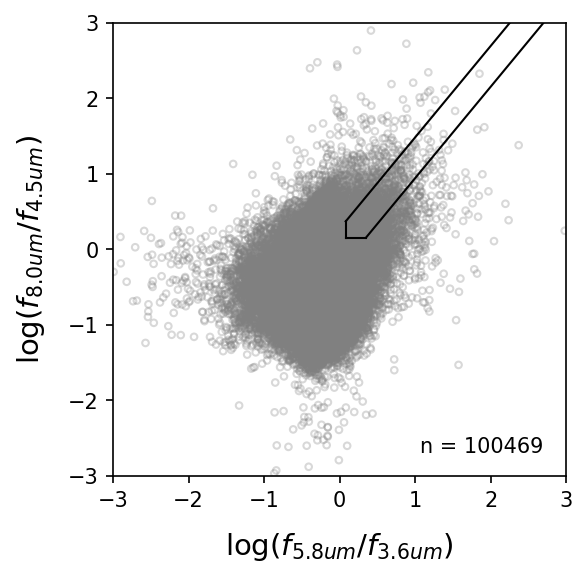

Galaxy count:  100469


In [22]:
##### plot all the galaxies with IRAC data

# plot 
plt.scatter(x, y, marker='o', c='none', edgecolor='gray', alpha=0.3, s=10)
# plt.scatter(x_agn, y_agn, marker='o', c='none', edgecolor='red', alpha=0.3, s=10)
myP.PlotDonleyWedge()

# format
plt.axis([-3,3,-3,3]) 
# plt.title('IRAC Ch4/Ch2 vs. Ch3/Ch1 for all COSMOS sources') 
plt.xlabel('$\log(f_{5.8um}/f_{3.6um})$') 
plt.ylabel('$\log(f_{8.0um}/f_{4.5um})$')
myP.addtext_n(len(x))

ax = plt.gca()
ax.set_aspect('equal')
ax.set_adjustable('box')

# myP.save(path_fig+'\NAME.png') # !!! give name if save
plt.show()

# print number of galaxies
print('Galaxy count: ', len(x))